In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [52]:
import os
import cv2
import shutil
import imutils
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from keras.applications import DenseNet169
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout

from toolkit import *

In [3]:
# Specify the GPU device (e.g., GPU 0)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print('GPU set')

GPU set


In [4]:
def copy_images_to_target_folder(target_subfolder, root_folder=os.getcwd(), data_folder='data/brain-tumor/train', image_name_prefix='image_yes',  
                                 data_subfolders=['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']):
    # Define the target subfolders (yes and no)
    target_subfolders = ['brain_tumor/yes', 'brain_tumor/no']

    # Check if the target subfolder exists in the list of target subfolders
    if target_subfolder not in target_subfolders:
        print(f"'{target_subfolder}' is not a valid target subfolder.")
        return

    # Define the target folder path
    target_path = join_paths(root_folder, target_subfolder)

    # Check if the target folder exists
    create_target_subfolder = False
    if check_path_existence(target_path):
        response = input(f"The target subfolder '{target_subfolder}' already exists. "
                         f"Copying from {data_folder}: {data_subfolders} to {target_path}. "
                         "Do you want to procced with copy? (yes/no): ")
        if response.lower() == 'yes':
            response = ''
            response = input("Do you want to delete and re-create the dataset? (yes/no): ")
            if response.lower() == 'yes':
                shutil.rmtree(target_path)
                print(f"{target_subfolder} subfolder deleted.")
                create_target_subfolder = True
            else:
                print('')
        else:
            print("No changes made. Exiting.")
            return
    else:
        create_target_subfolder = True

    # Create the target subfolder
    if create_target_subfolder:
        os.makedirs(target_path)
        print(f"Created target subfolder: {target_subfolder}")

    # Copy images from root_subfolders to the target subfolder
    total_count = 0
    for sub_folder in data_subfolders:
        source_path = join_paths(data_folder, sub_folder)
        print(f"Copying {source_path} to {target_path}")
        if join_paths(source_path):
            count = 0
            for filename in list_directory_contents(source_path):
                src_file = join_paths(source_path, filename)
                file_extension = os.path.splitext(filename)[-1]
                image_count = len(list_directory_contents(target_path))
                dest_file = join_paths(target_path, f'{image_name_prefix}_{image_count + 1}{file_extension}')
                shutil.copy(src_file, dest_file)
                count += 1
        total_count += count
    print(f'Dataset copied to {target_subfolder}, total count: {total_count}')
    print('-'*70)

In [5]:
# Create brain tumor dataset
copy_images_to_target_folder(target_subfolder='brain_tumor/yes')
copy_images_to_target_folder(target_subfolder='brain_tumor/no', data_subfolders=['no_tumor'], image_name_prefix='image_no')
copy_images_to_target_folder(data_folder='data/brain-tumor/test', target_subfolder='brain_tumor/yes')
copy_images_to_target_folder(data_folder='data/brain-tumor/test', target_subfolder='brain_tumor/no', 
                             data_subfolders=['no_tumor'], image_name_prefix='image_no')

Created target subfolder: brain_tumor/yes
Copying data/brain-tumor/train\glioma_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Copying data/brain-tumor/train\meningioma_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Copying data/brain-tumor/train\pituitary_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Dataset copied to brain_tumor/yes, total count: 2475
----------------------------------------------------------------------
Created target subfolder: brain_tumor/no
Copying data/brain-tumor/train\no_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/no
Dataset copied to brain_tumor/no, total count: 395
----------------------------------------------------------------------


The target subfolder 'brain_tumor/yes' already exists. Copying from data/brain-tumor/test: ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'] to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes. Do you want to procced with copy? (yes/no):  yes
Do you want to delete and re-create the dataset? (yes/no):  no



Copying data/brain-tumor/test\glioma_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Copying data/brain-tumor/test\meningioma_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Copying data/brain-tumor/test\pituitary_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/yes
Dataset copied to brain_tumor/yes, total count: 289
----------------------------------------------------------------------


The target subfolder 'brain_tumor/no' already exists. Copying from data/brain-tumor/test: ['no_tumor'] to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/no. Do you want to procced with copy? (yes/no):  yes
Do you want to delete and re-create the dataset? (yes/no):  no



Copying data/brain-tumor/test\no_tumor to D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning\brain_tumor/no
Dataset copied to brain_tumor/no, total count: 105
----------------------------------------------------------------------


In [6]:
def create_directory_structure(root_dir=os.getcwd(), top_dirs=None, sub_dirs=None):
    """
    Create a directory structure with top-level folders and subfolders.

    Args:
        root_dir (str, optional): The root directory where the structure will be created.
            Defaults to the current working directory.
        top_dirs (list, optional): List of top-level folder names. Defaults to ['model_data/train', 'model_data/test', 'model_data/val'].
        sub_dirs (list, optional): List of subfolder names within each top-level folder. Defaults to ['yes', 'no'].

    Returns:
        None
    """
    if top_dirs is None:
        top_dirs = ['model_data/train', 'model_data/test', 'model_data/val']
    if sub_dirs is None:
        sub_dirs = ['yes', 'no']

    for top_dir in top_dirs:
        top_dir_path = join_paths(root_dir, top_dir)
        os.makedirs(top_dir_path, exist_ok=True)
        
        for sub_dir in sub_dirs:
            sub_dir_path = join_paths(top_dir_path, sub_dir)
            os.makedirs(sub_dir_path, exist_ok=True)

    print(f'Directory structure created in: {root_dir}')

In [7]:
# Create new folders
create_directory_structure()

Directory structure created in: D:\UK-Data\2023\Learning\ML\Deep-Learning\Code-Repo\Deep-Learning


In [8]:
def move_n_images(src_folder, dest_folder, n=1):
    """
    Move the first 'n' images from a source folder to a destination folder.

    Args:
        src_folder (str): Path to the source folder.
        dest_folder (str): Path to the destination folder.
        n (int): Number of images to move. Default is 1.

    Returns:
        None
    """
    # Check if the source folder exists
    if not os.path.exists(src_folder):
        print(f"Source folder '{src_folder}' does not exist.")
        return

    # Check if the destination folder exists; if not, create it
    if not check_path_existence(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of files in the source folder
    files = list_directory_contents(src_folder)

    # Sort the files to ensure consistent order
    files.sort()

    # Move the first 'n' images to the destination folder
    count = 0
    for i in range(n):
        if i < len(files):
            src_file = join_paths(src_folder, files[i])
            dest_file = join_paths(dest_folder, files[i])
            shutil.move(src_file, dest_file)
            count += 1

    if n != count:
        print('Inconsistent move')
    else:
        print(f'Moved {n} images from {src_folder} to {dest_folder}')

In [9]:
# Split data by train/val/test
data_folder = 'brain_tumor'
for sub_folder in list_directory_contents(data_folder):
    sub_folder_path = join_paths(data_folder, sub_folder)
    sub_folder_image_count = len(list_directory_contents(sub_folder_path))
    print(f'total: {sub_folder_image_count}')
    
    # Move train images: 60%
    train_count = int(round(sub_folder_image_count * 0.6, 0))
    move_n_images(
        src_folder=sub_folder_path, 
        dest_folder=f'model_data/train/{sub_folder}', 
        n=train_count
    )

    # Move validation images: 20%
    val_count = int(round(sub_folder_image_count * 0.2, 0))
    move_n_images(
        src_folder=sub_folder_path, 
        dest_folder=f'model_data/val/{sub_folder}', 
        n=val_count
    )

    # Move test images: 20%
    test_count = sub_folder_image_count - (train_count + val_count)
    move_n_images(
        src_folder=sub_folder_path, 
        dest_folder=f'model_data/test/{sub_folder}', 
        n=test_count
    )

total: 500
Moved 300 images from brain_tumor\no to model_data/train/no
Moved 100 images from brain_tumor\no to model_data/val/no
Moved 100 images from brain_tumor\no to model_data/test/no
total: 2764
Moved 1658 images from brain_tumor\yes to model_data/train/yes
Moved 553 images from brain_tumor\yes to model_data/val/yes
Moved 553 images from brain_tumor\yes to model_data/test/yes


In [10]:
# Define data folders and image size
TRAIN_DATA_DIR = 'model_data/train/'
VAL_DATA_DIR = 'model_data/val/'
TEST_DATA_DIR = 'model_data/test/'
IMAGE_SIZE = (224, 224)

In [11]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    index = 0
    labels = dict()
    for path in tqdm(sorted(list_directory_contents(dir_path))):
        if not path.startswith('.'):
            labels[index] = path
            for file in list_directory_contents(join_paths(dir_path, path)):
                if not file.startswith('.'):
                    image = cv2.imread(join_paths(dir_path, path, file))
                    # Resize the image to the specified dimensions
                    image = cv2.resize(image, img_size)
                    X.append(image)
                    y.append(index)
            index += 1

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [12]:
# Load data
X_train, y_train, labels = load_data(TRAIN_DATA_DIR, IMAGE_SIZE)
X_val, y_val, _ = load_data(VAL_DATA_DIR, IMAGE_SIZE)
X_test, y_test, _ = load_data(TEST_DATA_DIR, IMAGE_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.59s/it]


1958 images loaded from model_data/train/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


653 images loaded from model_data/val/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]

653 images loaded from model_data/test/ directory.


In [13]:
def plot_class_counts(y_train, y_val, y_test):
    y = dict()
    y[0] = []
    y[1] = []
    for set_name in (y_train, y_val, y_test):
        y[0].append(np.sum(set_name == 0))
        y[1].append(np.sum(set_name == 1))

    data = {'Set': ['Train Set', 'Validation Set', 'Test Set'],
            'No': y[0],
            'Yes': y[1]}
    df = pd.DataFrame(data)

    # Define a custom color palette
    colors = sns.color_palette("husl", n_colors=2)  # You can choose a different palette if you prefer

    # Create the bar plot with custom aesthetics
    sns.set(style="whitegrid")  # Use a white grid background
    plt.figure(figsize=(8, 4))  # Set the figure size

    ax = sns.barplot(x='Set', y='Count', hue='Class', data=df.melt('Set', var_name='Class', value_name='Count'), palette=colors)

    plt.title('Count of classes in each set')
    plt.xlabel('Set')
    plt.ylabel('Count')
    plt.legend(loc='best')  # Add a legend with custom labels

    # Add data labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.show()

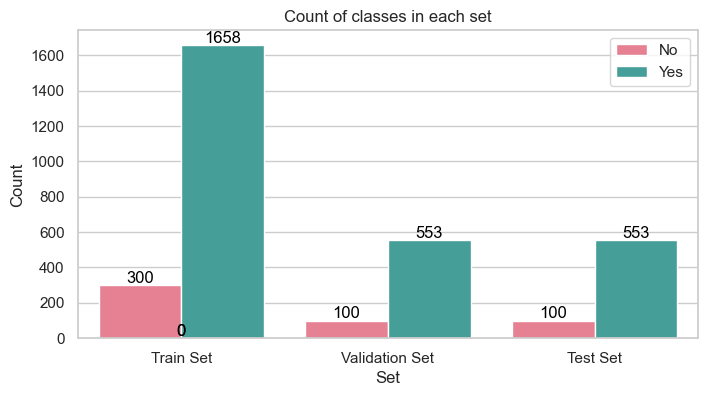

In [14]:
plot_class_counts(y_train, y_val, y_test)

In [15]:
def view_random_images(input_dir, num_images=5):
    """
    Display a row of random images from the specified directory.

    Args:
        input_dir (str): The path to the directory containing the images.
        num_images (int): The number of random images to display. Default is 5.

    Returns:
        None
    """
    # Get a list of image file paths in the input directory
    image_files = [join_paths(input_dir, filename) for filename in list_directory_contents(input_dir) 
                   if filename.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("No image files found in the specified directory.")
        return

    # Shuffle the image file list to select random images
    random.shuffle(image_files)

    # Limit the number of images to the specified 'num_images'
    image_files = image_files[:num_images]

    # Create a row of subplots for displaying images
    fig, axes = plt.subplots(1, num_images, figsize=(8, 5))

    for i, image_file in enumerate(image_files):
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

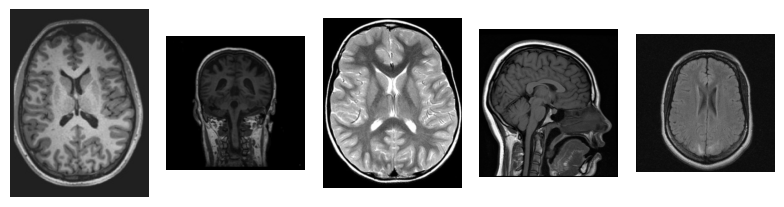

In [16]:
view_random_images(join_paths(TRAIN_DATA_DIR, 'no'))

In [17]:
def plot_samples(data_dir, num_images=10):
    # Get a list of subfolder names in the data directory
    subfolders = [subfolder for subfolder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subfolder))]

    # Loop through each subfolder
    for subfolder in subfolders:
        # Define the path to the tumor subfolder within the "Training" folder
        subfolder_path = os.path.join(data_dir, subfolder)
        print(f'Images path : {subfolder_path}')
        
        # Get a list of image files in the subfolder
        image_files = [filename for filename in os.listdir(subfolder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Randomly select 'num_images' images from the subfolder
        selected_images = random.sample(image_files, num_images)
        
        # Create a horizontal row for displaying the images
        fig, axes = plt.subplots(1, num_images, figsize=(16, 4))

        # Display the selected images in the row
        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(subfolder_path, image_file)
            img = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space for displaying
            axes[i].imshow(img_rgb)
            axes[i].axis('off')  # Turn off axis labels

        # Add a title at the bottom of the row using plt.title()
        plt.suptitle(f'Images for class: {subfolder}', fontsize=18, fontweight='bold', y=0.8)
            
        # Adjust subplot layout
        plt.tight_layout()
        
        # Display the plot
        plt.show()

Images path : model_data/train/no


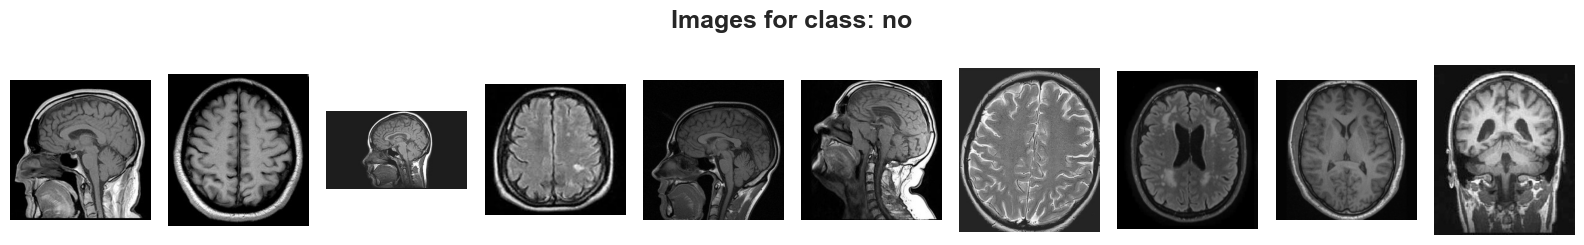

Images path : model_data/train/yes


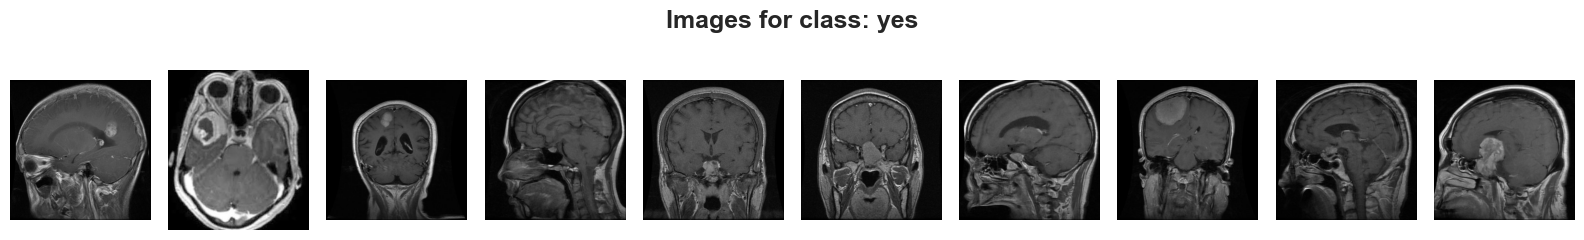

In [18]:
plot_samples(TRAIN_DATA_DIR)

In [19]:
def crop_images_in_directory(dir_path, IMAGE_SIZE=(224, 224), add_pixels_value=0):
    # Get a list of image files in the directory
    image_files = [filename for filename in list_directory_contents(dir_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]

    image_count = 0
    for filename in image_files:
        image_path = join_paths(dir_path, filename)

        # Read the image
        image = cv2.imread(image_path)

        # Perform image processing and cropping
        processed_image = process_image(image, IMAGE_SIZE, add_pixels_value)

        if processed_image is not None:
            # Replace the original image with the cropped image
            cv2.imwrite(image_path, processed_image)
            image_count += 1
    
    print(f"Cropped and replaced {image_count} images under {dir_path}")

def process_image(image, IMAGE_SIZE=(224, 224), add_pixels_value=0):
    if image is None:
        return None
    
    # Resize the image to the specified dimensions
    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)

    # Convert the image to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding, erosion, and dilation
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find the contours and grab the largest contour
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if not cnts:
        return None
    
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image
    ADD_PIXELS = add_pixels_value
    new_img = image[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()

    return new_img

In [20]:
# Cropping images in train and validation set
crop_images_in_directory(join_paths(TRAIN_DATA_DIR, 'yes'))
crop_images_in_directory(join_paths(TRAIN_DATA_DIR, 'No'))
crop_images_in_directory(join_paths(VAL_DATA_DIR, 'yes'))
crop_images_in_directory(join_paths(VAL_DATA_DIR, 'No'))

Cropped and replaced 1658 images under model_data/train/yes
Cropped and replaced 300 images under model_data/train/No
Cropped and replaced 553 images under model_data/val/yes
Cropped and replaced 100 images under model_data/val/No


Images path : model_data/train/no


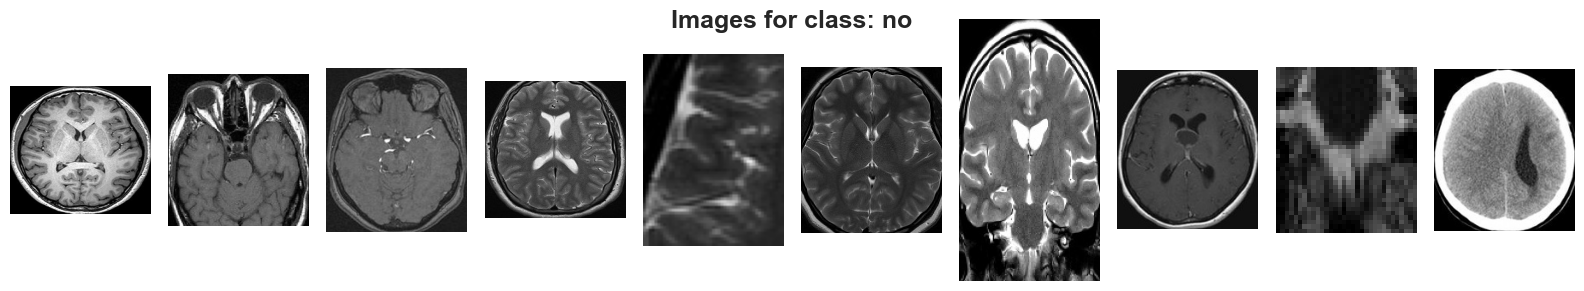

Images path : model_data/train/yes


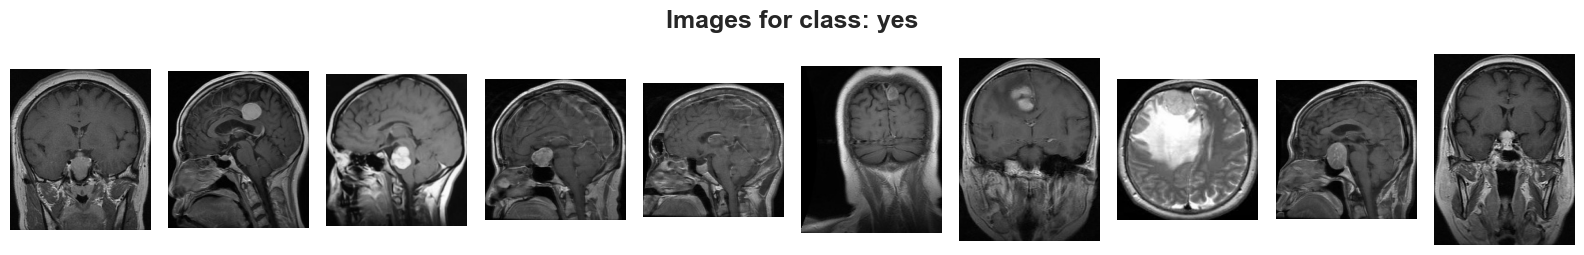

In [21]:
plot_samples(TRAIN_DATA_DIR)

In [22]:
def apply_augmentations_and_save(input_dir, augmentations):
    """
    Apply a list of augmentations to images in the specified directory and save the augmented images.

    Args:
        input_dir (str): The path to the directory containing the images.
        output_dir (str): The path to the directory where augmented images will be saved.
        augmentations (list): A list of dictionaries, each specifying an augmentation (e.g., {"type": "rotate", "param": 45}).

    Returns:
        None
    """
    # Get a list of image file paths in the input directory
    image_files = [join_paths(input_dir, filename) for filename in list_directory_contents(input_dir) 
                   if filename.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("No image files found in the specified directory.")
        return

    # Iterate through each image file and apply augmentations
    for image_file in image_files:
        img = cv2.imread(image_file)

        if img is not None:
            # Get the original file name without the extension
            base_filename, extension = os.path.splitext(os.path.basename(image_file))

            for augmentation in augmentations:
                augmentation_type = augmentation["type"]

                if augmentation_type == "rotate":
                    angle = augmentation["param"]
                    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    new_filename = f"{base_filename}_rot_{angle}{extension}"
                    save_path = join_paths(input_dir, new_filename)
                    cv2.imwrite(save_path, rotated_img)
                    print(f"Rotated and saved {image_file} as {new_filename}")

                elif augmentation_type == "flip":
                    flip_type = augmentation["param"]
                    flipped_img = cv2.flip(img, flip_type)
                    flip_name = "horizontal" if flip_type == 1 else "vertical"
                    new_filename = f"{base_filename}_flip_{flip_name}{extension}"
                    save_path = join_paths(input_dir, new_filename)
                    cv2.imwrite(save_path, flipped_img)
                    print(f"Applied {flip_name} flip and saved {image_file} as {new_filename}")

                elif augmentation_type == "jitter":
                    brightness_factor = augmentation["param"]["brightness"]
                    contrast_factor = augmentation["param"]["contrast"]
                    saturation_factor = augmentation["param"]["saturation"]
                    hue_factor = augmentation["param"]["hue"]
                    
                    # Convert image to float32 for color jittering
                    img_jitter = img.astype(np.float32) / 255.0

                    # Apply color jittering transformations
                    img_jitter = cv2.cvtColor(img_jitter, cv2.COLOR_BGR2HSV)
                    img_jitter[..., 2] *= brightness_factor
                    img_jitter[..., 1] *= contrast_factor
                    img_jitter[..., 1] = np.clip(img[..., 1], 0, 1)  # Clip contrast
                    img_jitter[..., 1] *= saturation_factor
                    img_jitter[..., 0] += 179 * hue_factor
                    img_jitter[..., 0] %= 180  # Wrap hue

                    # Convert back to BGR color space
                    img_jitter = cv2.cvtColor(img_jitter, cv2.COLOR_HSV2BGR)
                    img_jitter = (img_jitter * 255).clip(0, 255).astype(np.uint8)
                    new_filename = f"{base_filename}_jitter{extension}"
                    save_path = join_paths(input_dir, new_filename)
                    cv2.imwrite(save_path, img_jitter)
                    print(f"Applied color jittering and saved {image_file} as {new_filename}")

                elif augmentation_type == "edge":
                    threshold_1 = augmentation["param"]["threshold1"]
                    threshold_2 = augmentation["param"]["threshold2"]
                    
                    # Convert image to grayscale for edge detection
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Apply Canny edge detection
                    edge_img = cv2.Canny(gray_img, threshold_1, threshold_2)

                    # Convert edge-detected image back to BGR color space
                    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2BGR)
                    new_filename = f"{base_filename}_edge{extension}"
                    save_path = join_paths(input_dir, new_filename)
                    cv2.imwrite(save_path, edge_img)
                    print(f"Applied edge detection and saved {image_file} as {new_filename}")

                elif augmentation_type == "blur":
                    blur_type = augmentation["param"]["type"]
                    kernel_size = augmentation["param"]["kernel_size"]

                    if blur_type == "gaussian":
                        blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
                    elif blur_type == "average":
                        blurred_img = cv2.blur(img, (kernel_size, kernel_size))
                    elif blur_type == "median":
                        blurred_img = cv2.medianBlur(img, kernel_size)
                    elif blur_type == "bilateral":
                        blurred_img = cv2.bilateralFilter(img, kernel_size, sigmaColor=75, sigmaSpace=75)
                    else:
                        print(f"Invalid blur type '{blur_type}' for {image_file}. Skipping.")
                        continue
                    
                    new_filename = f"{base_filename}_{blur_type}_blur{extension}"
                    save_path = join_paths(input_dir, new_filename)
                    cv2.imwrite(save_path, blurred_img)
                    print(f"Applied {blur_type} blur and saved {image_file} as {new_filename}")

In [23]:
# Define and apply a list of augmentations on train no tumor class
augmentations = [
    {"type": "rotate", "param": 45},
    {"type": "flip", "param": 1},  # Horizontal flip
    {"type": "jitter", "param": {"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.5}},
    {"type": "edge", "param": {"threshold1": 30, "threshold2": 100}},
    {"type": "blur", "param": {"type": "bilateral", "kernel_size": 5}}
]
apply_augmentations_and_save(input_dir=join_paths(TRAIN_DATA_DIR, 'no'), augmentations=augmentations)

Rotated and saved model_data/train/no\image_no_1.jpg as image_no_1_rot_45.jpg
Applied horizontal flip and saved model_data/train/no\image_no_1.jpg as image_no_1_flip_horizontal.jpg
Applied color jittering and saved model_data/train/no\image_no_1.jpg as image_no_1_jitter.jpg
Applied edge detection and saved model_data/train/no\image_no_1.jpg as image_no_1_edge.jpg
Applied bilateral blur and saved model_data/train/no\image_no_1.jpg as image_no_1_bilateral_blur.jpg
Rotated and saved model_data/train/no\image_no_10.jpg as image_no_10_rot_45.jpg
Applied horizontal flip and saved model_data/train/no\image_no_10.jpg as image_no_10_flip_horizontal.jpg
Applied color jittering and saved model_data/train/no\image_no_10.jpg as image_no_10_jitter.jpg
Applied edge detection and saved model_data/train/no\image_no_10.jpg as image_no_10_edge.jpg
Applied bilateral blur and saved model_data/train/no\image_no_10.jpg as image_no_10_bilateral_blur.jpg
Rotated and saved model_data/train/no\image_no_100.jpg a

In [24]:
# Define and apply a list of augmentations on validation set no tumor class
augmentations = [
    {"type": "rotate", "param": 45},
    {"type": "flip", "param": 1},  # Horizontal flip
    {"type": "jitter", "param": {"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.5}},
    {"type": "blur", "param": {"type": "bilateral", "kernel_size": 5}}
]
apply_augmentations_and_save(input_dir=join_paths(VAL_DATA_DIR, 'no'), augmentations=augmentations)

Rotated and saved model_data/val/no\image_no_37.jpg as image_no_37_rot_45.jpg
Applied horizontal flip and saved model_data/val/no\image_no_37.jpg as image_no_37_flip_horizontal.jpg
Applied color jittering and saved model_data/val/no\image_no_37.jpg as image_no_37_jitter.jpg
Applied bilateral blur and saved model_data/val/no\image_no_37.jpg as image_no_37_bilateral_blur.jpg
Rotated and saved model_data/val/no\image_no_370.jpg as image_no_370_rot_45.jpg
Applied horizontal flip and saved model_data/val/no\image_no_370.jpg as image_no_370_flip_horizontal.jpg
Applied color jittering and saved model_data/val/no\image_no_370.jpg as image_no_370_jitter.jpg
Applied bilateral blur and saved model_data/val/no\image_no_370.jpg as image_no_370_bilateral_blur.jpg
Rotated and saved model_data/val/no\image_no_371.jpg as image_no_371_rot_45.jpg
Applied horizontal flip and saved model_data/val/no\image_no_371.jpg as image_no_371_flip_horizontal.jpg
Applied color jittering and saved model_data/val/no\ima

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.07s/it]


3458 images loaded from model_data/train/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


1053 images loaded from model_data/val/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]

653 images loaded from model_data/test/ directory.


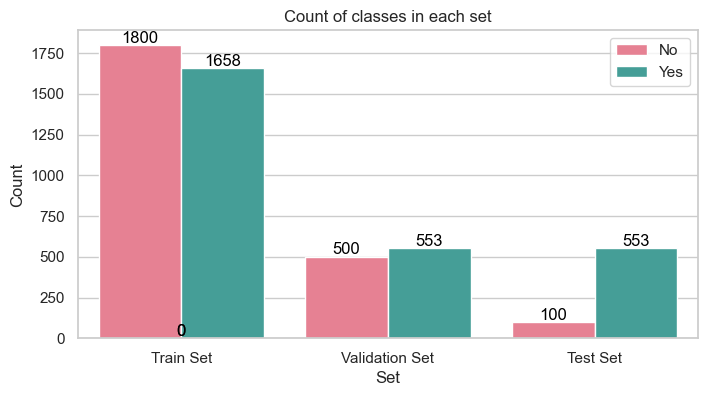

In [25]:
# Load and plot data
X_train, y_train, labels = load_data(TRAIN_DATA_DIR, IMAGE_SIZE)
X_val, y_val, _ = load_data(VAL_DATA_DIR, IMAGE_SIZE)
X_test, y_test, _ = load_data(TEST_DATA_DIR, IMAGE_SIZE)

# Plotting
plot_class_counts(y_train, y_val, y_test)

In [26]:
def preprocess_images(dataset, image_size=(224, 224)):
    new_dataset = []
    for image in dataset:
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_CUBIC)
        new_dataset.append(preprocess_input(image))
    return np.array(new_dataset)

In [27]:
X_train_prep = preprocess_images(X_train)
X_val_prep = preprocess_images(X_val)
X_test_prep = preprocess_images(X_test)

In [29]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [30]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    color_mode='rgb',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR,
    color_mode='rgb',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=42
)

Found 3458 images belonging to 2 classes.
Found 1053 images belonging to 2 classes.


In [31]:
def create_model():
    input_shape = (224, 224, 3)
    
    # Create the base neural network
    base_Neural_Net = DenseNet169(input_shape=input_shape, weights='imagenet', include_top=False)
    
    # Create the model
    model = Sequential()
    model.add(base_Neural_Net)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Set the base neural network layers to be non-trainable
    for layer in base_Neural_Net.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', 'AUC']
    )
    
    # Print the model summary
    model.summary()
    
    return model

In [32]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               20873472  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 256)               0

In [33]:
EPOCHS = 50

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

C:\Users\thaku\AppData\Local\Temp\ipykernel_1364\3293565748.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - 22s 224ms/step - loss: 0.6433 - accuracy: 0.7175 - auc: 0.7856 - val_loss: 0.9231 - val_accuracy: 0.7025 - val_auc: 0.8494
Epoch 2/50
50/50 [==============================] - 10s 195ms/step - loss: 0.4030 - accuracy: 0.8037 - auc: 0.8921 - val_loss: 0.4704 - val_accuracy: 0.7825 - val_auc: 0.8736
Epoch 3/50
50/50 [==============================] - 9s 185ms/step - loss: 0.3320 - accuracy: 0.8512 - auc: 0.9323 - val_loss: 0.3785 - val_accuracy: 0.8125 - val_auc: 0.9104
Epoch 4/50
50/50 [==============================] - 10s 198ms/step - loss: 0.3294 - accuracy: 0.8675 - auc: 0.9340 - val_loss: 0.3679 - val_accuracy: 0.8400 - val_auc: 0.9297
Epoch 5/50
50/50 [==============================] - 9s 185ms/step - loss: 0.3000 - accuracy: 0.8700 - auc: 0.9459 - val_loss: 0.3699 - val_accuracy: 0.8300 - val_auc: 0.9264
Epoch 6/50
50/50 [==============================] - 9s 187ms/step - loss: 0.2852 - accuracy: 0.8788 - auc: 0.9524 - val_loss: 0

In [34]:
# Save the model to a file
model.save('brain_tumor_model.h5')

In [35]:
# Load the saved model
loaded_model = tf.keras.models.load_model('brain_tumor_model.h5')

In [36]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Parameters:
    - cm: Confusion matrix (a 2D NumPy array)
    - classes: List of class labels (e.g., class names)
    - normalize: If True, normalize the confusion matrix
    - title: Title of the plot
    - cmap: Colormap for the plot
    
    Returns:
    None
    """
    # Create a new figure with a specified size
    plt.figure(figsize=(6, 6))
    
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Set the title of the plot
    plt.title(title)
    
    # Add a colorbar to the plot
    plt.colorbar()
    
    # Create tick marks for the classes on both axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Set a threshold for text color in the cells
    thresh = cm.max() / 2.
    
    # Iterate through the confusion matrix cells and add text labels
    cm = np.round(cm, 2)  # Round the values to two decimal places
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # Add labels for the x and y axes
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Display the plot
    plt.show()

In [48]:
def binary_classification_prediction(model_path, image_path, threshold=0.5):
    """
    Make binary class prediction using a pre-trained TensorFlow model.

    Args:
        model_path (str): Path to the saved model file (e.g., .h5).
        image_path (str): Path to the image file for prediction.
        threshold (float): Threshold for binary classification (default is 0.5).

    Returns:
        int: Binary class prediction (0 or 1).
    """
    try:
        # Load the pre-trained model
        model = tf.keras.models.load_model(model_path)

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Make predictions
        predictions = model.predict(x)

        # Classify based on the threshold
        if predictions[0][0] > threshold:
            binary_class = 1  # Class 1
        else:
            binary_class = 0  # Class 0

        # Calculate match percentage
        match_percentage = predictions[0][0] * 100 if binary_class == 1 else (1 - predictions[0][0]) * 100

        return binary_class, match_percentage

    except Exception as e:
        return None

In [49]:
binary_class, match_percentage = binary_classification_prediction('brain_tumor_model.h5', 'image_test/image (59).jpg')
if binary_class is not None:
    print(f'Binary Class: {binary_class}')
    print(f'Match Percentage: {match_percentage:.2f}%')
else:
    print('Error: Unable to make predictions.')

1/1 [==============================] - 2s 2s/step
Binary Class: 0
Match Percentage: 92.44%
